<a href="https://colab.research.google.com/github/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/08/0807.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
%%capture
!pip install umap-learn umap-learn[plot] kneed
!wget -O 0807_barcodes.tsv https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/data/0807_barcodes.tsv?raw=1
!wget -O 0807_genes.tsv https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/data/0807_genes.tsv?raw=1
!wget -O 0807_matrix.mtx https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/data/0807_matrix.mtx?raw=1
!wget -O 0807_pmbc_3k_cell_types.json https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/data/0807_pmbc_3k_cell_types.json?raw=1

## Single-cell rna demo

In [6]:
import json

import pandas as pd
import numpy as np

from scipy.io import mmread # load sparse matrix

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

from yellowbrick.cluster import SilhouetteVisualizer

import umap
import umap.plot as uplot

from kneed import KneeLocator
import random

random.seed(12)

sns.set_theme()

## Load the data

Single-cell RNA sequencing (scRNA-seq) is a technique used to study the gene expression patterns of individual cells.


In [16]:
# Load the dataset
# tsv: \t separated file
cell_names_path = '0807_barcodes.tsv' # cell name
gene_names_path = '0807_genes.tsv' # gene name
data_path = '0807_matrix.mtx' # sparse matrix of count data

cell_names = pd.read_csv(cell_names_path, sep='\t', header=None)[0]
gene_names = pd.read_csv(gene_names_path, sep='\t', header=None)[1]
type(cell_names)

pandas.core.series.Series

In [17]:
# Load cell annotations
cell_annotations_path = '0807_pmbc_3k_cell_types.json' # ground truth cell type
fle = open(cell_annotations_path, 'r')
cell_type_dict = json.load(fle)
fle.close()

In [18]:
cell_type_dict # (cell_name -> cell_type)

{'AAACATACAACCAC-1': 'Memory CD4 T',
 'AAACATTGAGCTAC-1': 'B-cells',
 'AAACATTGATCAGC-1': 'Memory CD4 T',
 'AAACCGTGCTTCCG-1': 'CD14+ Mono',
 'AAACCGTGTATGCG-1': 'NK cells',
 'AAACGCACTGGTAC-1': 'Memory CD4 T',
 'AAACGCTGACCAGT-1': 'CD8 T',
 'AAACGCTGGTTCTT-1': 'CD8 T',
 'AAACGCTGTAGCCA-1': 'Naive CD4 T',
 'AAACGCTGTTTCTG-1': 'FCGR3A+ Mono',
 'AAACTTGAAAAACG-1': 'B-cells',
 'AAACTTGATCCAGA-1': 'Naive CD4 T',
 'AAAGAGACGAGATA-1': 'Naive CD4 T',
 'AAAGAGACGCGAGA-1': 'CD14+ Mono',
 'AAAGAGACGGACTT-1': 'Naive CD4 T',
 'AAAGAGACGGCATT-1': 'Naive CD4 T',
 'AAAGCAGATATCGG-1': 'CD14+ Mono',
 'AAAGCCTGTATGCG-1': 'Memory CD4 T',
 'AAAGGCCTGTCTAG-1': 'B-cells',
 'AAAGTTTGATCACG-1': 'B-cells',
 'AAAGTTTGGGGTGA-1': 'B-cells',
 'AAAGTTTGTAGAGA-1': 'Naive CD4 T',
 'AAAGTTTGTAGCGT-1': 'CD14+ Mono',
 'AAATCAACAATGCC-1': 'B-cells',
 'AAATCAACACCAGT-1': 'Naive CD4 T',
 'AAATCAACCAGGAG-1': 'Naive CD4 T',
 'AAATCAACCCTATT-1': 'FCGR3A+ Mono',
 'AAATCAACGGAAGC-1': 'Naive CD4 T',
 'AAATCAACTCGCAA-1': 'Memory 

In [19]:
# Show cell names
cell_names.head()

,0
0,AAACATACAACCAC-1
1,AAACATTGAGCTAC-1
2,AAACATTGATCAGC-1
3,AAACCGTGCTTCCG-1
4,AAACCGTGTATGCG-1


In [20]:
# Show gene names
gene_names.head()

,1
0,MIR1302-10
1,FAM138A
2,OR4F5
3,RP11-34P13.7
4,RP11-34P13.8


In [21]:
# Load expression matrix
expression_mtx = mmread(data_path)

In [22]:
# Show shapes
print('Expression shape : {}'.format(expression_mtx.shape))
print('Num cells : {}'.format(cell_names.shape))
print('Num genes : {}'.format(gene_names.shape))

Expression shape : (32738, 2700)
Num cells : (2700,)
Num genes : (32738,)


In [23]:
# Create dataframe from sparse matrix
expression_df = pd.DataFrame.sparse.from_spmatrix(
    expression_mtx,
    columns=cell_names.to_numpy(),
    index=gene_names.to_numpy()
)

In [24]:
expression_df.iloc[1300:1320, 1100:1120]

,CCGCTATGTGCAAC-1,CCGCTATGTGCACA-1,CCGGTACTGTCCTC-1,CCGTACACAAGCAA-1,CCGTACACAGCGTT-1,CCGTACACGTCATG-1,CCGTACACGTTGGT-1,CCGTACACTAACGC-1,CCTAAACTTTCGTT-1,CCTAAGGACCCAAA-1,CCTAAGGACTAGCA-1,CCTAAGGAGGGCAA-1,CCTAAGGATGATGC-1,CCTAAGGATGTCAG-1,CCTACCGACTCTTA-1,CCTACCGAGGGATG-1,CCTAGAGAGGTGAG-1,CCTATAACCAAAGA-1,CCTATAACGAGACG-1,CCTATAACTCAGAC-1
RP11-131L23.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RP11-290M5.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CYR61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RP11-290M5.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZNHIT6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
COL24A1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ODF2L,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
CLCA2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CLCA1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CLCA4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Quality controll

In [25]:
# Get count sum for all genes/cels
gene_sum = expression_df.sum(axis=1)
cell_sum = expression_df.sum(axis=0)

In [29]:
type(gene_sum)

pandas.core.series.Series

In [28]:
gene_sum, cell_sum

(MIR1302-10      0.0
 FAM138A         0.0
 OR4F5           0.0
 RP11-34P13.7    0.0
 RP11-34P13.8    0.0
                ... 
 AC145205.1      0.0
 BAGE5           0.0
 CU459201.1      0.0
 AC002321.2      0.0
 AC002321.1      0.0
 Length: 32738, dtype: Sparse[float64, 0],
 AAACATACAACCAC-1    2421.0
 AAACATTGAGCTAC-1    4903.0
 AAACATTGATCAGC-1    3149.0
 AAACCGTGCTTCCG-1    2639.0
 AAACCGTGTATGCG-1     981.0
                      ...  
 TTTCGAACTCTCAT-1    3461.0
 TTTCTACTGAGGCA-1    3447.0
 TTTCTACTTCCTCG-1    1684.0
 TTTGCATGAGAGGC-1    1024.0
 TTTGCATGCCTCAC-1    1985.0
 Length: 2700, dtype: Sparse[float64, 0])

In [30]:
# denoise
# Remove all genes that are not expressed
expression_df = expression_df.loc[
    gene_sum[gene_sum>3].index,
    cell_sum[cell_sum>10].index
].sparse.to_dense().T # columns are features and rows are samples

In [31]:
expression_df.shape # we have managed to remove around 60% of the genes

(2700, 13164)

In [32]:
# detect damaged cells
# Detect mitohondrial genes
mito_genes = [gene for gene in expression_df.columns if gene.startswith('MT-')]
mito_df = expression_df.loc[:, mito_genes]

# Calculate values that will be QC-ed
mito_df_sum = mito_df.sum(axis=1)
expression_df_sum = expression_df.sum(axis=1)
expression_df_num_genes = (expression_df>0).sum(axis=1) # number of nonzero genes for each cell

percent_mt = mito_df_sum/expression_df_sum*100

In [33]:
# Function for median deviation calculation
# median absolute deviation
def mad_qc(data, limit='upper'):
    # Calculate the median of the data
    median = np.median(data)

    # Calculate the absolute deviations from the median
    absolute_deviations = np.abs(data - median)

    # Calculate the median absolute deviation
    mad = np.median(absolute_deviations)

    if limit == 'upper':
        upper_limit = median + 3*mad
        return data > upper_limit # true for each cell that should be removed
    elif limit =='lower':
        lower_limit = median - 3*mad
        return data < lower_limit
    else:
        raise Exception('Incorrect choice for limit')

In [34]:
# Perform QC based on three criteria
mito_qc = mad_qc(percent_mt, limit='upper')
expression_sum_qc = mad_qc(expression_df_sum, limit='lower')
num_genes_qc = mad_qc(expression_df_num_genes, limit='lower')

# remove all the cells that are marked fro removal by either of these criteria
final_qc = mito_qc | expression_sum_qc | num_genes_qc

In [35]:
final_qc

,0
AAACATACAACCAC-1,False
AAACATTGAGCTAC-1,True
AAACATTGATCAGC-1,False
AAACCGTGCTTCCG-1,False
AAACCGTGTATGCG-1,False
...,...
TTTCGAACTCTCAT-1,False
TTTCTACTGAGGCA-1,False
TTTCTACTTCCTCG-1,False
TTTGCATGAGAGGC-1,False


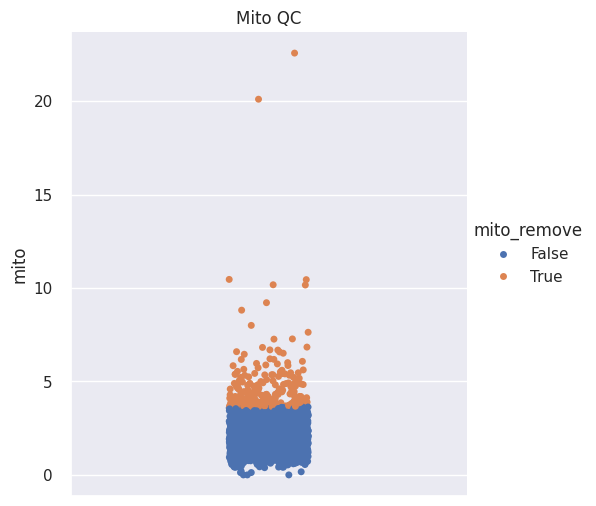

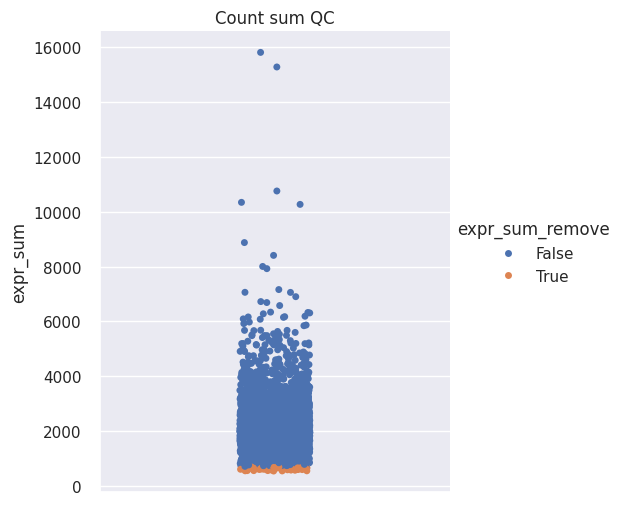

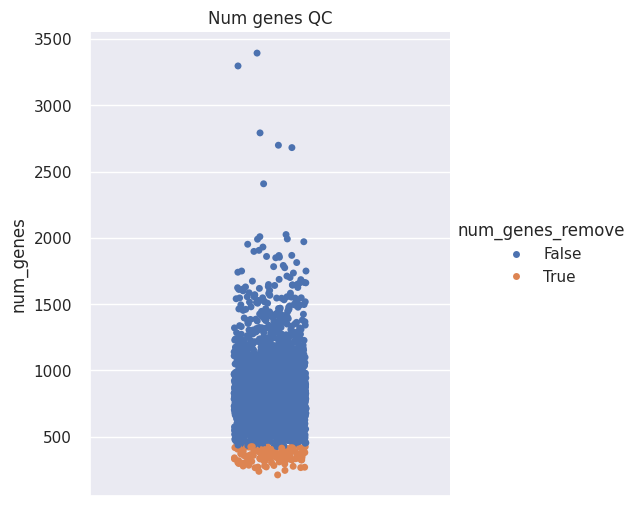

In [36]:
# Concatenate all QC data and QC results into
# a single dataframe
qc_df = pd.concat(
    [
        percent_mt.to_frame(name='mito'),
        expression_df_sum.to_frame(name='expr_sum'),
        expression_df_num_genes.to_frame(name='num_genes'),
        mito_qc.to_frame(name='mito_remove'),
        expression_sum_qc.to_frame(name='expr_sum_remove'),
        num_genes_qc.to_frame(name='num_genes_remove')
    ],
    axis=1
)

# Plot results
# catplot: similar to boxplot, but plot the individual data points instead of the boxes
sns.catplot(qc_df, y='mito',hue='mito_remove').set(title='Mito QC')
# we have number of cells that are marked for removal based on a high percentage of mitochondrial RNA
sns.catplot(qc_df, y='expr_sum',hue='expr_sum_remove').set(title='Count sum QC')
sns.catplot(qc_df, y='num_genes',hue='num_genes_remove').set(title='Num genes QC')

In [37]:
# Print number of eliminated and retained cells (data points)
final_qc.value_counts()

,count
False,2411
True,289


In [38]:
# Drop low quality cells
expression_df = expression_df.drop(
    index=final_qc[final_qc==True].index,
    errors='ignore'
)

In [39]:
# Remove cells without labels
cells_with_no_label = set(expression_df.index) - set(cell_type_dict.keys())
expression_df = expression_df.drop(index=cells_with_no_label)

### Normalization


In [40]:
# fix different sequencing efficiency across cells
# Normalize expression of all genes in each cell by using sum of gene expressions in each cell
expression_df = expression_df.div(
    expression_df_sum[expression_df.index],
    axis=0
)*10000


Text(0, 0.5, 'Variance')

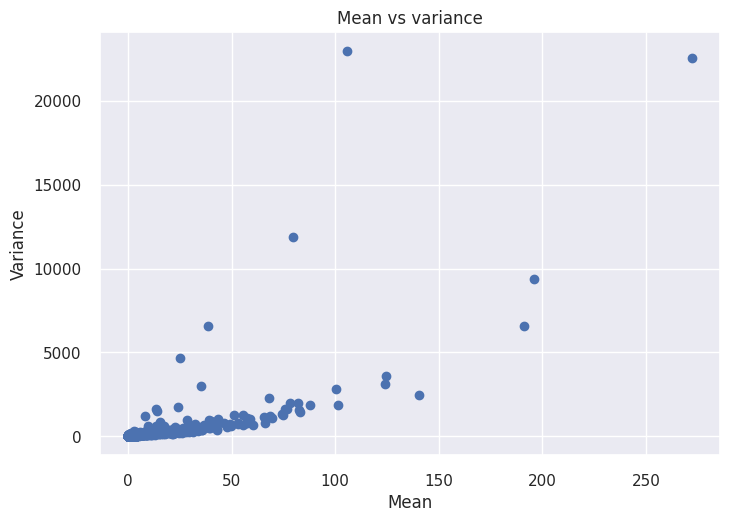

In [41]:
# mean variance ratio
gene_mean = expression_df.mean(axis=0)
gene_var =  expression_df.var(axis=0)

plt.scatter(gene_mean.to_numpy(), gene_var.to_numpy())
plt.title('Mean vs variance')
plt.xlabel('Mean')
plt.ylabel('Variance')

Text(0, 0.5, 'Count')

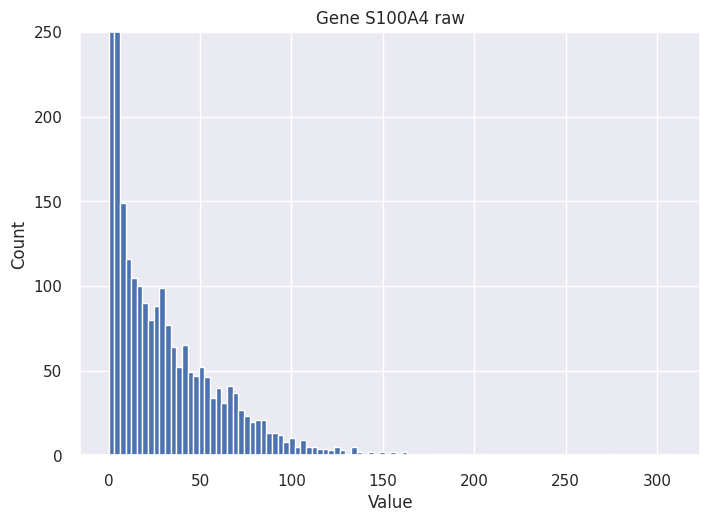

In [42]:
expression_df['S100A4'].hist(bins=100)
plt.ylim([0,250])
plt.title('Gene S100A4 raw')
plt.xlabel('Value')
plt.ylabel('Count') # some of our features are skewed

In [43]:
# log transform
# Log normalize the data
expression_df = np.log(expression_df + 1)

full_expression_df = expression_df.copy()

Text(0, 0.5, 'Log - Variance')

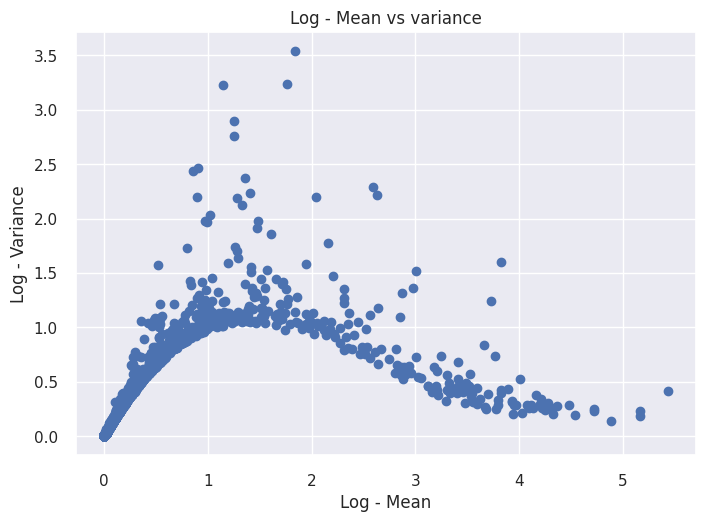

In [46]:
gene_mean = expression_df.mean(axis=0)
gene_var =  expression_df.var(axis=0)

plt.scatter(gene_mean.to_numpy(), gene_var.to_numpy())
plt.title('Log - Mean vs variance')
plt.xlabel('Log - Mean')
plt.ylabel('Log - Variance')
# we have managed to break the mean variance relationship to some extent,
# but still we have this relationship which still is problematic
# this relationship will not trouble us when we perform PCA, UMAP, clustering,
# but this will be problematic when we perform feature selection

Text(0, 0.5, 'Log - Count')

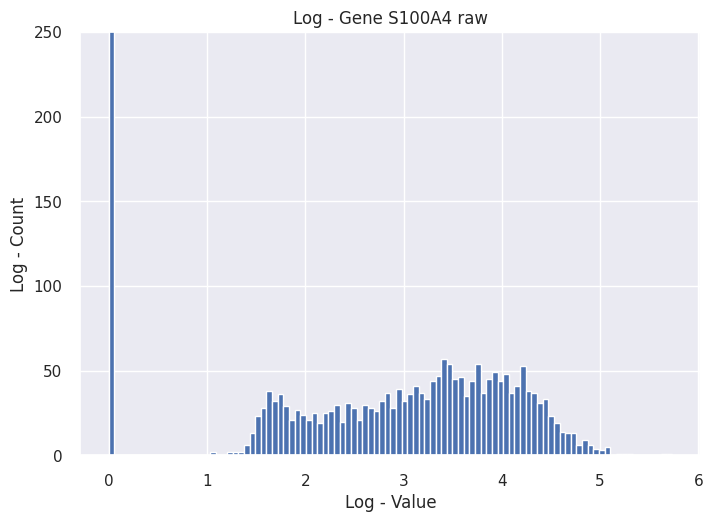

In [45]:
expression_df['S100A4'].hist(bins=100)
plt.ylim([0,250])
plt.title('Log - Gene S100A4 raw')
plt.xlabel('Log - Value')
plt.ylabel('Log - Count')
# we have managed to remove the skewness

### Feature selection

In [47]:
# in order to select features based on their variability, we will take care of the curvy relaitonship
# we will use the variance mean ratio in combination with binning

# Add everything to data frame
gene_df = pd.concat([gene_mean, gene_var], axis=1)
gene_df.columns = ['mean', 'var']

# Bin the data
num_bins = 20
bin_labels = [i for i in range(num_bins)]
gene_df['bin'] = pd.cut(gene_df['mean'], bins=num_bins, labels=bin_labels) # binning

In [48]:
gene_df['bin'].value_counts() # number of cells across bins
# the majority of cells will end up in the first bin

,count
bin,
0,11846
1,752
2,201
3,106
4,55
5,36
6,25
13,17
10,17


Text(0, 0.5, 'Log - Variance')

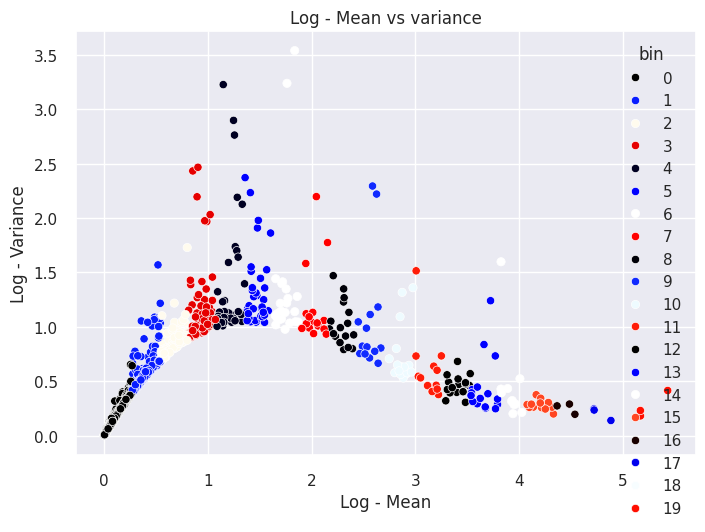

In [49]:
sns.scatterplot(gene_df, x='mean', y='var', hue='bin', palette='flag')
plt.title('Log - Mean vs variance')
plt.xlabel('Log - Mean')
plt.ylabel('Log - Variance')
# we have broken this complex relationship into a multiple segments
# where the mean variance relationship is approximately linear
# we will use the variance mean ratio in each bin

In [50]:
# Find variance to mean ratio
gene_df['dispersion'] = gene_df['var'] / gene_df['mean']

In [51]:
# we will perform standard scaling of this dispersion measure in each bin
# in order to make values comparable between bins
# this will basically result in choosing the most variable genes from each bin
# Find mean and standard deviation for each group
gene_df_grouped = gene_df.groupby('bin')['dispersion']
bin_means = gene_df_grouped.mean()
# ddof: degree of freedom; we will replace n with n-1 in the standard deviation formula
bin_stds = gene_df_grouped.std(ddof=1)

<ipython-input-51-37e3d53ccd5e>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gene_df_grouped = gene_df.groupby('bin')['dispersion']


In [54]:
# standard scaling
# Normalize dispersion inside each bin
gene_df['dispersions_norm'] = (
    gene_df['dispersion'].to_numpy() - bin_means[gene_df['bin'].to_numpy()].to_numpy()
) / bin_stds[gene_df['bin'].to_numpy()].to_numpy()

ValueError: cannot reindex on an axis with duplicate labels

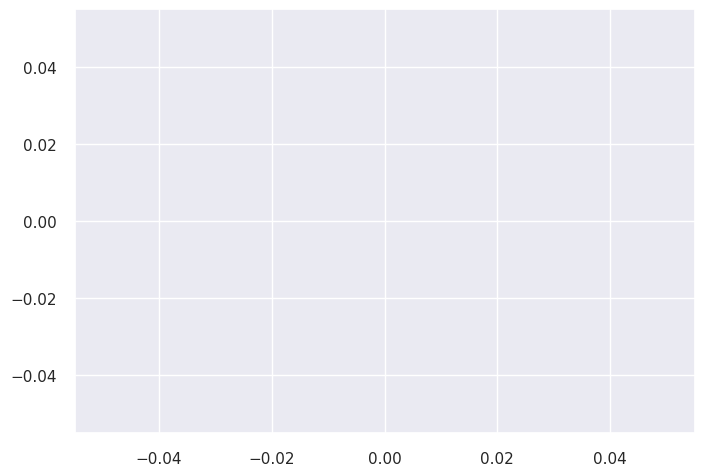

In [55]:
sns.scatterplot(gene_df, x='mean', y='dispersions_norm')

plt.title('Log - Mean vs custom dispersion')
plt.xlabel('Log - Mean')
plt.ylabel('Log - Custom dispersion')
# we have managed to break the relationship between a mean and variance

In [56]:
# now we can use this dispersion measure in order to select the most variable genes
# based on their biological variation
# Sort genes by coefficient of variation
gene_df = gene_df.sort_values('dispersions_norm', ascending=False)

# Keep 2000 genes with highest coefficient of variation
highly_variable_genes = gene_df.index[:2000]

# Subset the expression matrix to highly variable genes
expression_df = expression_df.loc[:, highly_variable_genes]

## Dimensionality reduction


In [ ]:
# Run PCA
pca = PCA()
pca_transformed_data = pca.fit_transform(expression_df.to_numpy())

In [ ]:
# Perform knee detection
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)*100

kneedle = KneeLocator(
    range(len(cumulative_explained_variance)),
    cumulative_explained_variance,
    S=1.0,
    curve="concave",
    direction="increasing"
)
kneedle.plot_knee()

Number of principal components is choosen to be 50. This is frequent choice for this analysis type.

In [ ]:
# Extract subset of principal components
elbow_point = kneedle.elbow
pca_transformed_data = pca_transformed_data[:, :50]

In [ ]:
# Run umap
umap_obj = umap.UMAP()
embedding = umap_obj.fit_transform(pca_transformed_data)

#### Following peripheral blood mononuclear cells (PBMCs) are present in this dataset.


- **B Cells**
  - **What They Do**: Make "tags" (antibodies) that stick to germs and mark them for destruction.
  - **Main Role**: Help the immune system recognize and remember germs.
  - **Why Different**: Only cells that make antibodies to tag specific germs.

<!-- Empty Line After Main Bullet -->


- **Dendritic Cells (DCs)**
  - **What They Do**: Capture germs and show pieces to other immune cells.
  - **Main Role**: Alert the immune system about invaders.
  - **Why Different**: Messengers between the first-line and specialized immune defenses.

<!-- Empty Line After Main Bullet -->


- **CD14+ Monocytes**
  - **What They Do**: Suck up germs, break them apart, and can change into macrophages.
  - **Main Role**: Clean up and later transform into tissue-specific cells for ongoing defense.
  - **Why Different**: Versatile; can transform and become part of tissue defenses.

<!-- Empty Line After Main Bullet -->


- **Natural Killer (NK) cells**
  - **What They Do**: Patrol and kill infected or cancerous cells without needing specific tags.
  - **Main Role**: Quick response to a wide range of problems.
  - **Why Different**: Can act without needing to recognize specific germs.

<!-- Empty Line After Main Bullet -->


- **CD8 T cells**
  - **What They Do**: Directly kill infected or cancerous cells.
  - **Main Role**: Eliminate specifically tagged cells.
  - **Why Different**: The "assassins" that directly kill target cells.

<!-- Empty Line After Main Bullet -->


- **Naive CD4 T cells**
  - **What They Do**: Wait to be activated to fight specific germs.
  - **Main Role**: Ready to be trained for fighting specific invaders.
  - **Why Different**: Untrained soldiers waiting for their first mission.

<!-- Empty Line After Main Bullet -->


- **Memory CD4 T cells**
  - **What They Do**: Remember past germs and react faster next time.
  - **Main Role**: Quick response to known threats.
  - **Why Different**: The immune system's "record keepers."

<!-- Empty Line After Main Bullet -->

- **FCGR3A+ Monocytes**
  - **What They Do**: Work with antibodies to make them more effective at tagging germs.
  - **Main Role**: Boost the effectiveness of antibodies.
  - **Why Different**: Have a special "hook" (FCGR3A) that enhances their cooperation with antibodies.

<!-- Empty Line After Main Bullet -->


- **Platelets**
  - **What They Do**: Help blood to clot.
  - **Main Role**: Stop bleeding.
  - **Why Different**: Not directly involved in fighting germs but crucial for preventing blood loss.



In [ ]:
# Plot umap embedding and display cell types
labels = [cell_type_dict[cell_id] if cell_id in cell_type_dict else 'none' for cell_id in expression_df.index ]
uplot.points(umap_obj, labels=np.array(labels))

## Attempt to cluster the data with K-means

In [ ]:
inertia_list = []
silhouette_score_list = []

# List used to store clusterings
clustering_result_dict = {}

# List used to store k means objects
k_means_list = []

num_clusters = range(3,15)

for num_clust in num_clusters:

    # Perform clustering for current number of clusters
    kmeans = KMeans(n_clusters=num_clust, n_init='auto', random_state=42)
    kmeans.fit(pca_transformed_data)

    k_means_list.append(kmeans)

    # Calculate inertia
    inertia_list.append(kmeans.inertia_)

    # Add clustering result to list
    silhouette_scr = silhouette_score(pca_transformed_data, kmeans.labels_)
    silhouette_score_list.append(silhouette_scr)

    clustering_result_dict[num_clust] = np.array(kmeans.labels_)


In [ ]:
# Siluethe plot
plt.plot(num_clusters, silhouette_score_list)
plt.title('Silhouette score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score value')

In [ ]:
# Plot inertia plot and curve
kneedle = KneeLocator(
    num_clusters,
    inertia_list,
    S=2,
    curve="convex",
    direction="decreasing"
)
kneedle.plot_knee()

In [ ]:
uplot.points(umap_obj, labels=np.array(labels))

In [ ]:
umap.plot.connectivity(umap_obj, show_points=True,labels=np.array(labels))

In [ ]:
umap.plot.diagnostic(umap_obj, diagnostic_type='pca')

In [ ]:
num_clust_list = [3,4,5,6,7,8,9]

# Initialize the grid of plots
fig, axs = plt.subplots(
    len(num_clust_list), 3,
    figsize=(16, 30)
)

tab10 = list(matplotlib.colormaps['tab10'].colors)

# Loop to populate the grid with plots
for i in range(len(num_clust_list)):

    sns.scatterplot(
        x=embedding[:,0],
        y=embedding[:,1],
        hue=clustering_result_dict[num_clust_list[i]],
        ax=axs[i, 0],
        s=3, palette='tab10'
    )

    visualizer = SilhouetteVisualizer(
        k_means_list[i],
        is_fitted=True,
        colors=tab10,
        ax=axs[i, 1]
    )

    visualizer = visualizer.fit(pca_transformed_data)

    sns.scatterplot(
        x=embedding[:,0],
        y=embedding[:,1],
        hue=np.array(labels),
        ax=axs[i, 2],
        s=3, palette='tab10'
    )
    axs[i,0].set_title('K-means clusters, K={}'.format(num_clust_list[i]))
    axs[i,1].set_title('True cell types')

plt.show()


In [ ]:
adj_rand_score_list = []
for clust_num in clustering_result_dict:

    adj_rand_score_list.append(adjusted_rand_score(clustering_result_dict[clust_num], labels))

plt.plot(clustering_result_dict.keys(), adj_rand_score_list)
plt.title('Adjusted rand score')

### Describing the clusters - K=7

In [ ]:
# Get cells bellonging to cluster 6
current_clust = clustering_result_dict[7]
current_clust

bcells_idx = np.where(current_clust==6)
other_clust_idx = np.where(current_clust!=6)

In [ ]:
from scipy.stats import mannwhitneyu

result_df = pd.DataFrame(columns=['ratio', 'pvalue'])

# Iterate through genes
for gene in full_expression_df.columns:

    # Get expression values for current gene
    curr_gene_exp = full_expression_df[gene].to_numpy()

    # Extract values belinging to cluster 2
    bcells_exp = curr_gene_exp[bcells_idx]
    # Extract values belonging to other clusters
    other_exp = curr_gene_exp[other_clust_idx]

    # Find ration of mean values
    mean_bcells = np.mean(bcells_exp) + 0.0001
    mean_others = np.mean(other_exp) + 0.0001

    ratio = mean_bcells/mean_others

    # Perform statistical testing
    ranksum_res = mannwhitneyu(bcells_exp, other_exp, alternative='greater')

    if ranksum_res.pvalue is not None:
        result_df.loc[gene, 'ratio'] = ratio
        result_df.loc[gene, 'pvalue'] = ranksum_res.pvalue

In [ ]:
result_df['pvalue'] = pd.to_numeric(result_df['pvalue'], errors='coerce')

In [ ]:
result_df.sort_values(['pvalue', 'ratio'], ascending=True).head(10)

In [ ]:
uplot.points(
    umap_obj,
    values=full_expression_df['MS4A1'].to_numpy(),
    width=600, height=600
)
plt.title('MS4A1 gene expression - B-cell marker')

In [ ]:
uplot.points(
    umap_obj,
    values=full_expression_df['CD79A'].to_numpy(),
    width=600, height=600
)
plt.title('CD79A gene expression - B-cell marker')